In [1]:
import tensorflow as tf
from tensorflow import keras
import theano.tensor as T
import pymc3 as pm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
tfmodel = keras.models.load_model('../test_grid_model.h5')

In [3]:
tfmodel.summary()

Model: "test_grid_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
outputs (Dense)              (None, 3)                 33        
Total params: 173
Trainable params: 173
Non-trainable params: 0
_________________________________________________________________


In [4]:
weights_list = tfmodel.get_weights()

In [5]:
def nn(input):
    nh_layers = int(len(weights_list) / 2 - 2)
    xx = T.nnet.elu(pm.math.dot(input, weights_list[0]) + weights_list[1])
    for hl in range(1, 1+nh_layers):
        xx = T.nnet.elu(pm.math.dot(xx, weights_list[hl * 2]) + weights_list[hl * 2 + 1])
    xx = pm.math.dot(xx, weights_list[-2]) + weights_list[-1]
    return 10**(xx)

In [6]:
params = ['star_age', 'initial_mass']
obs = ['radius', 'effective_T', 'delta_nu']

In [7]:
nn([np.log10(4.5), np.log10(1.0)]).eval()

array([1.14267237e+00, 6.08204420e+03, 1.13291452e+02])

In [8]:
Nstars = 10
ages = np.random.rand(Nstars) * 3.0 + 2.0
masses = np.random.randn(Nstars) * 0.05 + 1.0
inputs = np.array([ages , masses]).T
outputs = nn(inputs).eval()

In [9]:
obs_unc = np.array([[0.01, 70.0, 1.0] for n in range(Nstars)])
obs_ = outputs + np.random.randn(*outputs.shape) * obs_unc
print(obs_.shape)

(10, 3)


In [10]:
model = pm.Model()

with model:
    mass = pm.Normal('mass', 1.0, 0.2, shape=Nstars)
    age = pm.Normal('age', 4.5, 3.0, shape=Nstars)
    
    slist = [[age[m], mass[m]] for m in range(Nstars)]
    obs_prop = pm.Deterministic('obs_prop', nn(T.stacklists(slist)))
    
    like_r = pm.Normal('like_r', obs_prop[:, 0], obs_unc[:, 0], observed=obs_[:, 0])
    like_T = pm.Normal('like_T', obs_prop[:, 1], obs_unc[:, 1], observed=obs_[:, 1])
    y = obs_prop[:, 2] - obs_[:, 2]
    X = obs_prop[:, 2][:, None]
    
    cov_func = 1.0 * pm.gp.cov.ExpQuad(1, ls=30)
    gp = pm.gp.Marginal(cov_func=cov_func)
    y_ = gp.marginal_likelihood("y_", X=X, y=y, noise=obs_unc[:, 2])

/Users/davies/Library/Python/3.7/lib/python/site-packages/pymc3/gp/cov.py:93: UserWarning: Only 1 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  " the number of columns to use. Ignore otherwise.", UserWarning)
/Users/davies/Library/Python/3.7/lib/python/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [11]:
inits = ['adapt_diag']
start = {'mass': [1.0 for n in range(Nstars)], 'age': [4.5 for n in range(Nstars)]}

with model:
    trace = pm.sample(tune=1000, init=inits[0], start=start, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
/Users/davies/Library/Python/3.7/lib/python/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/davies/Library/Python/3.7/lib/python/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/davies/Library/Python/3.7/lib/python/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional index

/Users/davies/Library/Python/3.7/lib/python/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/davies/Library/Python/3.7/lib/python/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/davies/Library/Python/3.7/lib/python/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In th

/Users/davies/Library/Python/3.7/lib/python/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/davies/Library/Python/3.7/lib/python/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


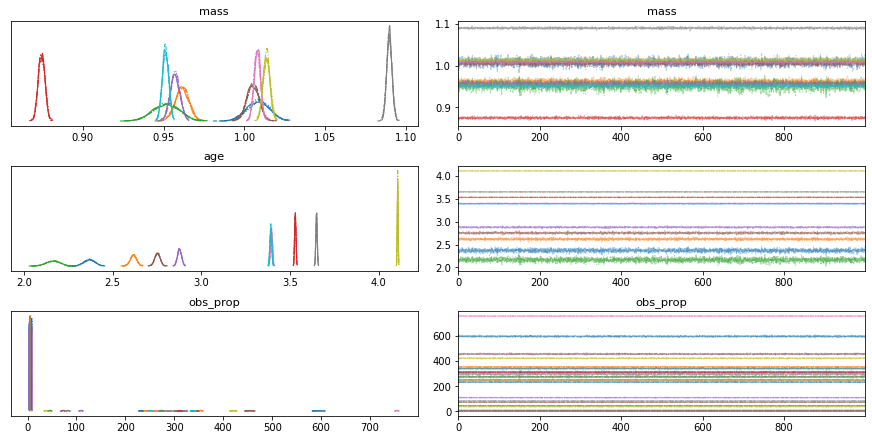

In [12]:
pm.traceplot(trace);

In [13]:
pm.summary(trace)

/Users/davies/Library/Python/3.7/lib/python/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/davies/Library/Python/3.7/lib/python/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mass[0],1.009,0.007,0.995,1.021,0.000,0.000,3743.0,3743.0,3748.0,3162.0,1.0
mass[1],0.961,0.004,0.954,0.969,0.000,0.000,3364.0,3363.0,3353.0,2787.0,1.0
mass[2],0.952,0.008,0.937,0.967,0.000,0.000,3812.0,3812.0,3810.0,2534.0,1.0
mass[3],0.875,0.002,0.871,0.878,0.000,0.000,5138.0,5136.0,5133.0,3123.0,1.0
mass[4],0.957,0.003,0.952,0.963,0.000,0.000,3526.0,3526.0,3530.0,2626.0,1.0
mass[5],1.005,0.004,0.998,1.012,0.000,0.000,3685.0,3685.0,3682.0,3021.0,1.0
mass[6],1.008,0.002,1.004,1.012,0.000,0.000,3999.0,3999.0,4007.0,2513.0,1.0
mass[7],1.090,0.002,1.087,1.093,0.000,0.000,4408.0,4407.0,4422.0,2507.0,1.0
mass[8],1.014,0.002,1.010,1.018,0.000,0.000,4215.0,4215.0,4218.0,2786.0,1.0
mass[9],0.951,0.002,0.947,0.955,0.000,0.000,4231.0,4231.0,4234.0,2721.0,1.0


1.0135984646745073 1.0085336356098407
0.961890455218091 0.961442712944697
0.9529692836060799 0.9516875340503339
0.8726196802869003 0.874560690512637
0.9553654337302897 0.9570965373773007
1.0044289459501592 1.0052497166975791
1.0098064780781593 1.0079065314892606
1.0897995758458034 1.0896175886075685
1.0100898940174952 1.0137204656121825
0.9534237867112423 0.9511252815959381


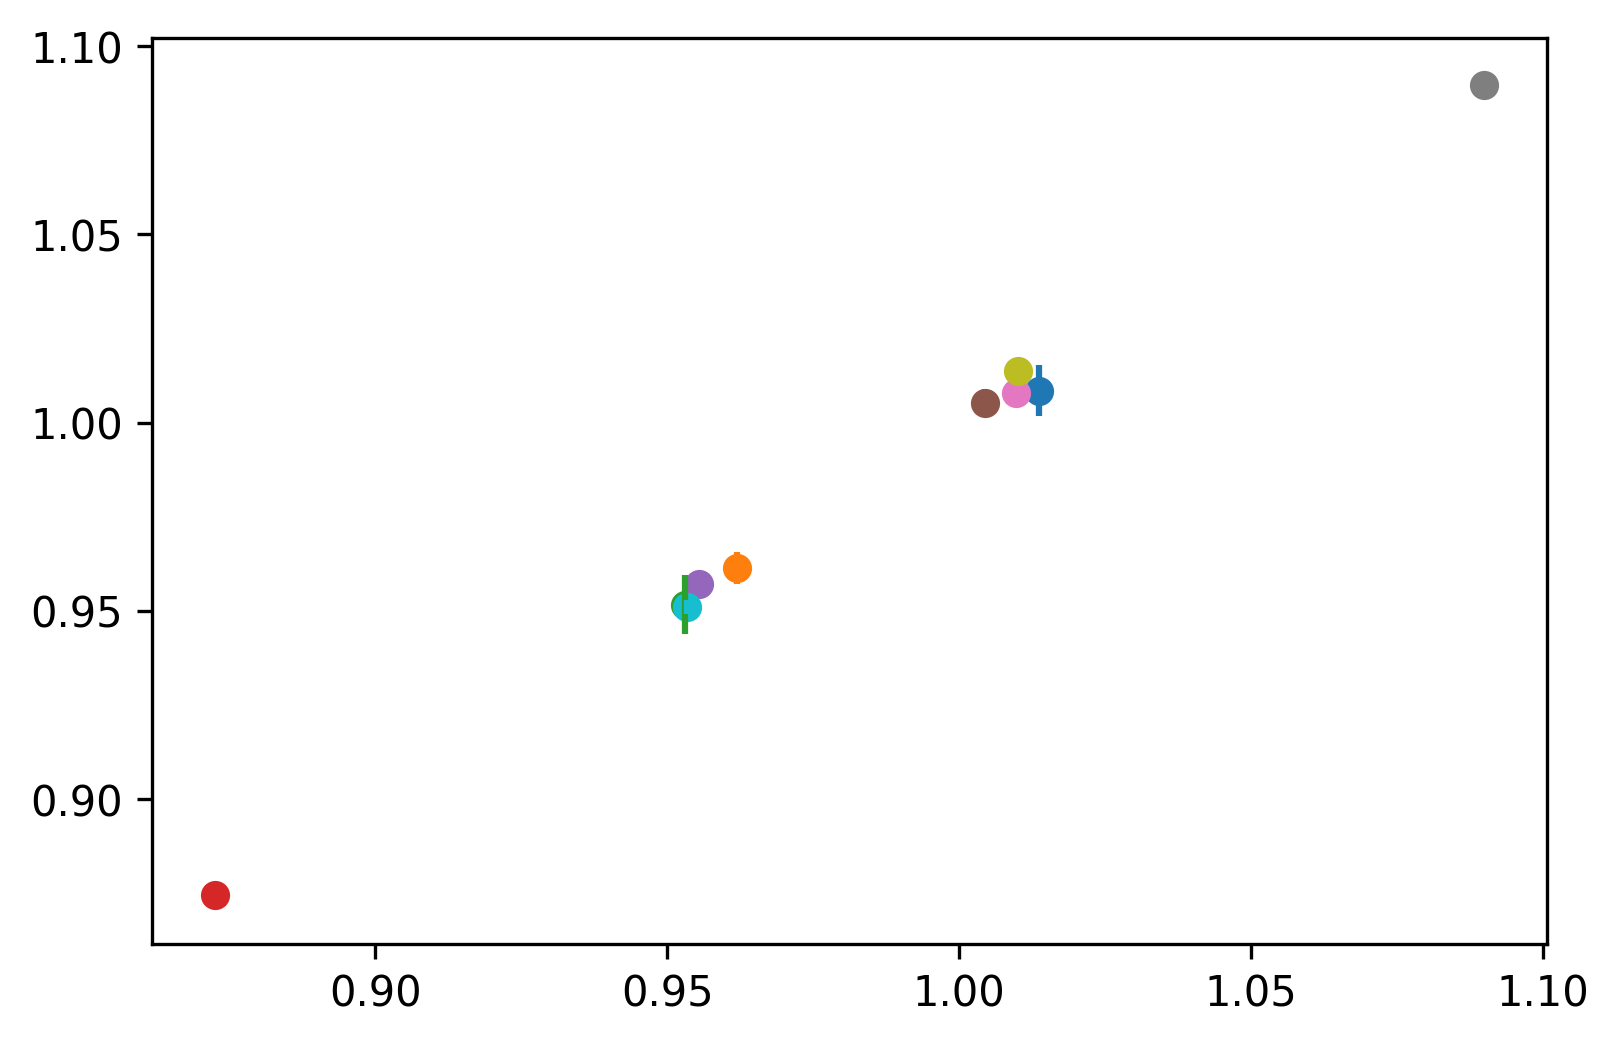

In [14]:
fig, ax = plt.subplots(dpi=300)
for idx, i in enumerate(masses):
    print(i, np.mean(trace['mass'][:, idx]))
    ax.scatter(i, np.mean(trace['mass'][:, idx]))
    ax.errorbar(i, np.mean(trace['mass'][:, idx]), yerr=np.std(trace['mass'][:, idx]))

In [15]:
Xnew = np.linspace(40, 250, 200)[:, None]

with model:
    f_star = gp.conditional("f_star", Xnew=Xnew)

/Users/davies/Library/Python/3.7/lib/python/site-packages/pymc3/gp/cov.py:93: UserWarning: Only 1 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  " the number of columns to use. Ignore otherwise.", UserWarning)
/Users/davies/Library/Python/3.7/lib/python/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [16]:
with model:
    pred_samples = pm.sample_posterior_predictive(trace, vars=[f_star], samples=2000)

/Users/davies/Library/Python/3.7/lib/python/site-packages/pymc3/sampling.py:1618: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


/Users/davies/Library/Python/3.7/lib/python/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/davies/Library/Python/3.7/lib/python/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


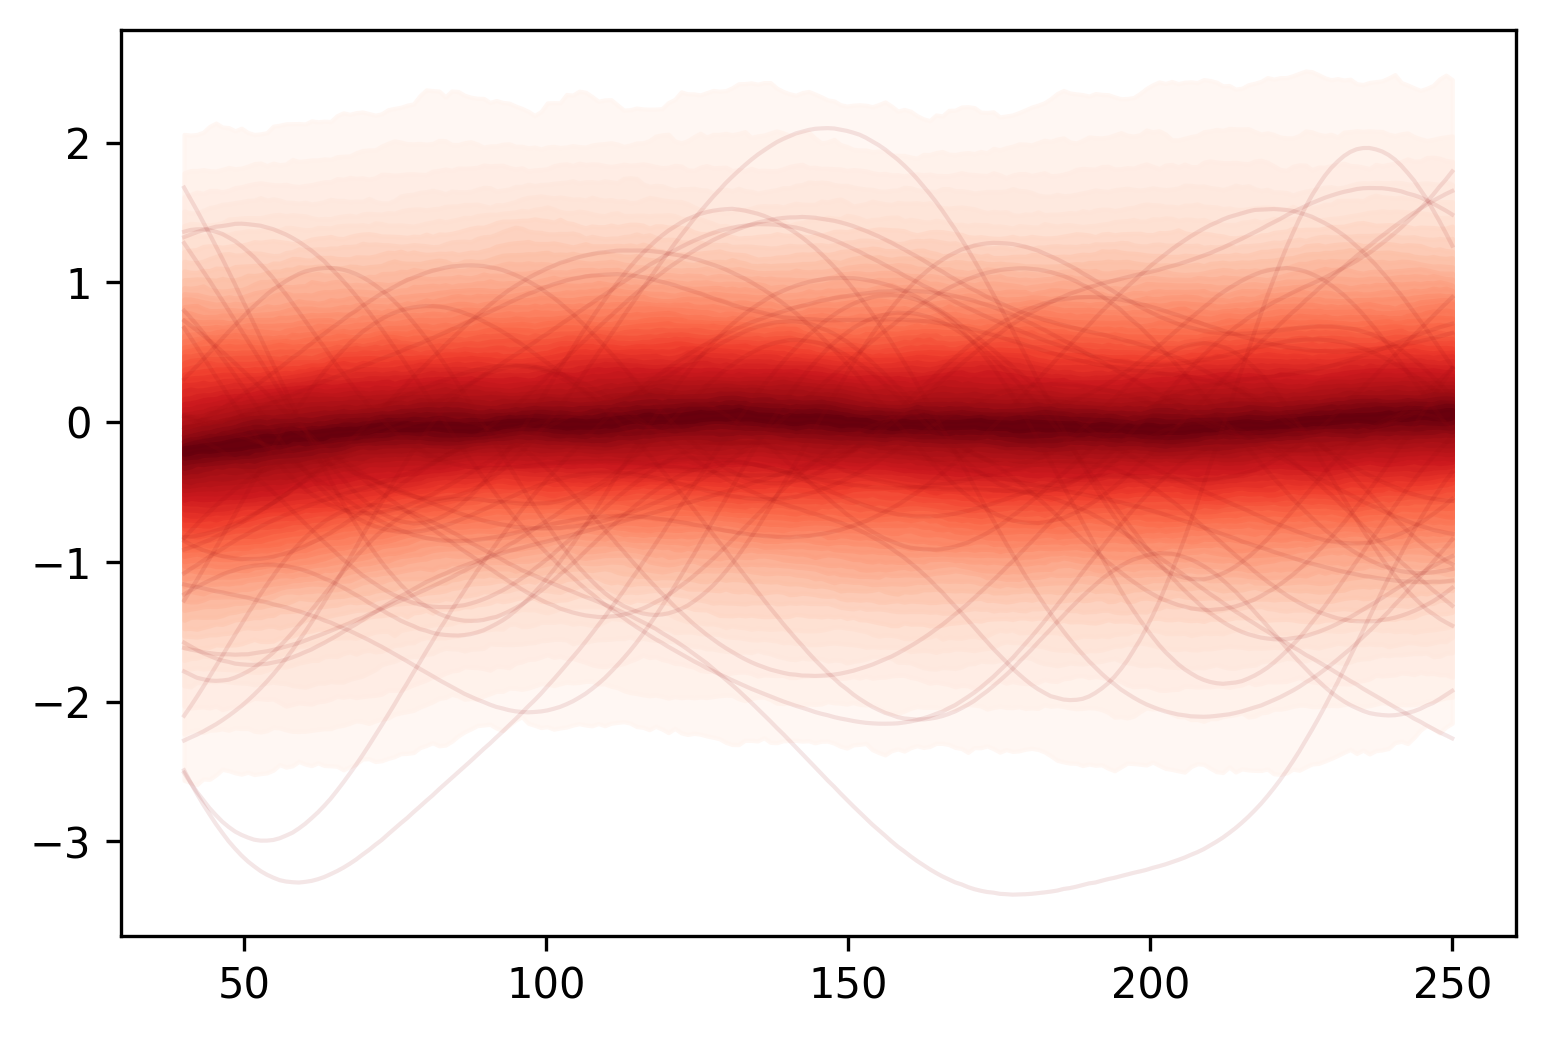

In [17]:
fig = plt.figure(dpi=300); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_star"], Xnew);